In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import norm,probplot
from sklearn.preprocessing import QuantileTransformer

In [2]:
%%time
train = pd.read_csv('D:/下载/学习文档/房价预测—中文思路/train.csv',header=0,index_col=0)
test = pd.read_csv('D:/下载/学习文档/房价预测—中文思路/test.csv',header=0,index_col=0)
train_data = train.copy()
test_data = test.copy()

CPU times: total: 0 ns
Wall time: 34.8 ms


In [3]:
train_data.shape,test_data.shape

((1460, 80), (1459, 79))

In [4]:
# 拼接在一起，一起处理
df = pd.concat([train_data.iloc[:,:-1],test_data])
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


In [5]:
# 查看上面挑选出的列中是否有缺失值
use_columns = ['OverallQual','GrLivArea','GarageArea','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd'] + ['Foundation','BsmtQual','KitchenQual']
df[use_columns].isnull().sum()

OverallQual      0
GrLivArea        0
GarageArea       1
TotalBsmtSF      1
FullBath         0
YearBuilt        0
YearRemodAdd     0
Foundation       0
BsmtQual        81
KitchenQual      1
dtype: int64

In [6]:
# 发现BsmtQual的缺失较多，使用随机抽样法补充缺失值
set(df['BsmtQual'])

{'Ex', 'Fa', 'Gd', 'TA', nan}

In [7]:
df['BsmtQual'].value_counts()

BsmtQual
TA    1283
Gd    1209
Ex     258
Fa      88
Name: count, dtype: int64

In [8]:
null_col = ['BsmtQual','KitchenQual']
# 利用概率统计中的概念对类别变量的缺失值进行填充
freqDict = {}
total = df.shape[0]
for col in null_col:
    for v in set(df[col]):
        # 每一个类别的df
        vdf = df[df[col] == v][col]
        # 每一个类别的概率
        freqDict[v] = vdf.shape[0] / total
    freqTuple = list(freqDict.items())
    freqList = [i[1] for i in freqTuple]
    freqCumsum = np.cumsum(freqList)


    for i in range(total):
        if df.loc[i+1,col] != df.loc[i+1,col]:  # 说明为空值
            # 这一部分运用了概率统计中的概念
            a = random.random()
            for k in range(len(freqCumsum)-1):
                if freqCumsum[k]<a<=freqCumsum[k+1]:
                    position = k+1
            df.loc[i+1,col] = freqTuple[position][0]

In [9]:
df['BsmtQual'].isnull().sum()

0

In [10]:
df['KitchenQual'].isnull().sum()

0

In [11]:
# GarageArea，TotalBsmtSF这两个连续变量均只有一个缺失值，所以用均值来填充（正常来说要先剔除异常点，因为缺失的不多，所以这一步就跳过了）
df.loc[df['GarageArea'].isnull(),'GarageArea'] = df['GarageArea'].mean()
df.loc[df['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = df['TotalBsmtSF'].mean()

In [12]:
df['GarageArea'].isnull().sum()

0

In [13]:
df['TotalBsmtSF'].isnull().sum()

0

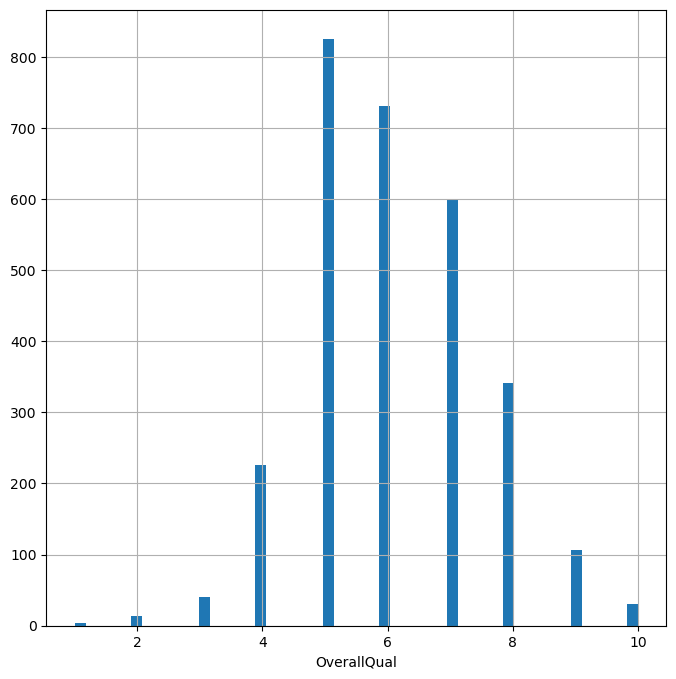

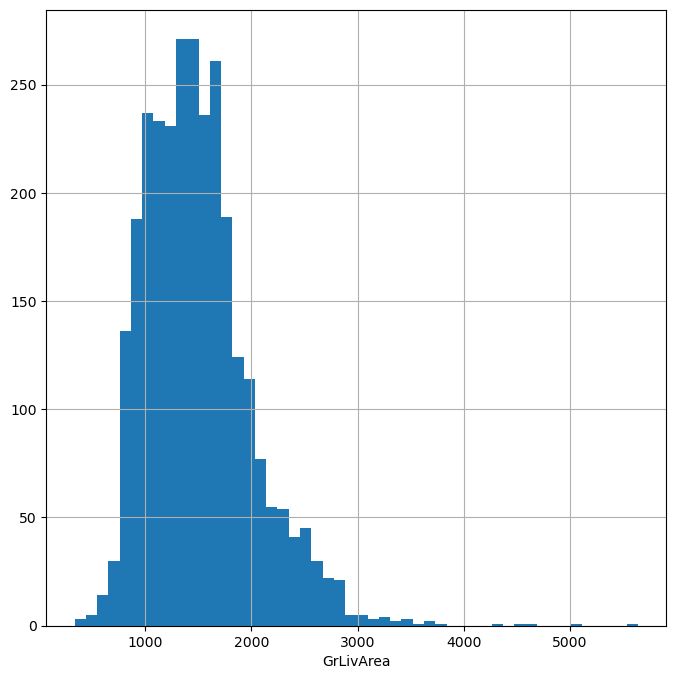

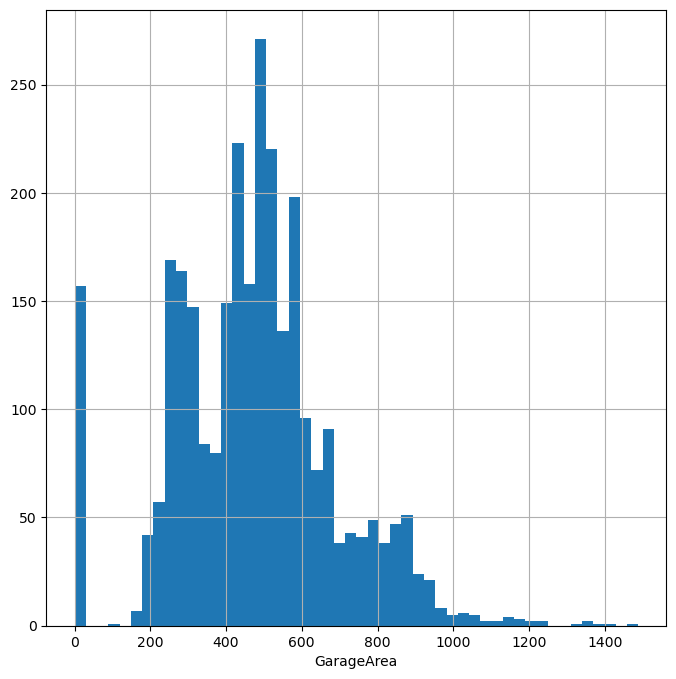

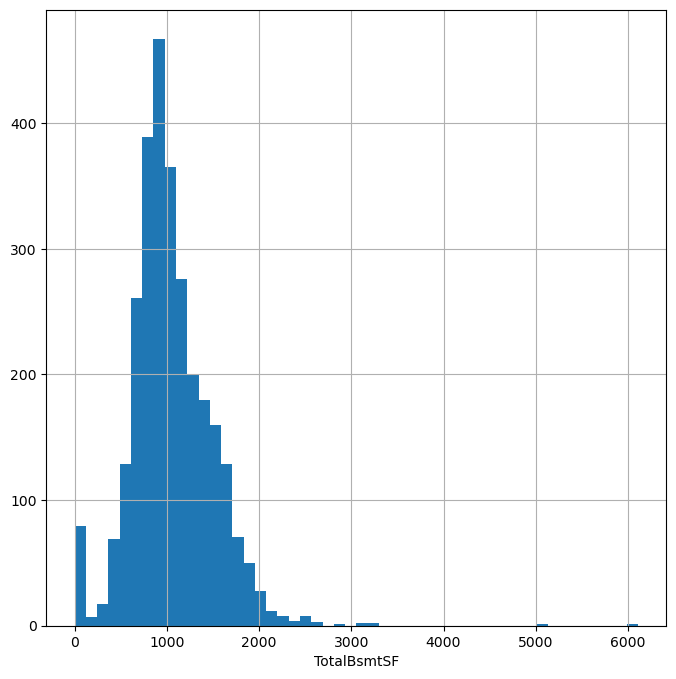

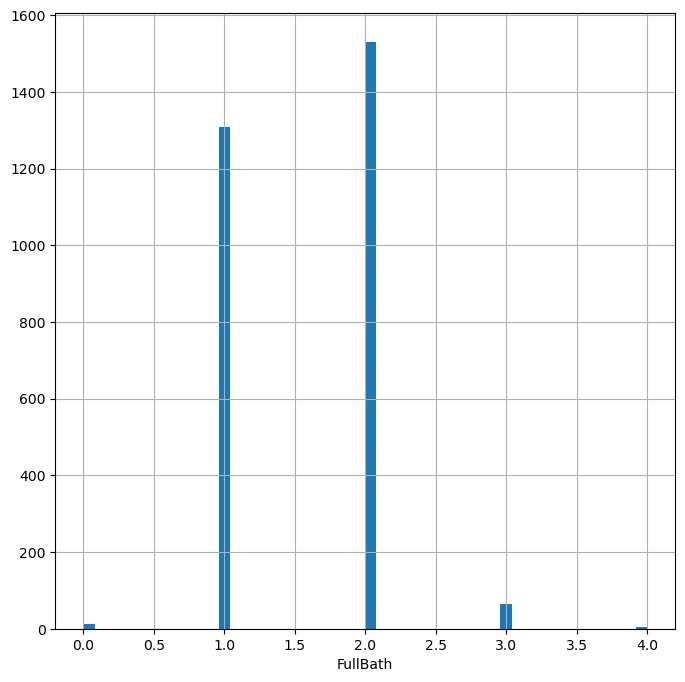

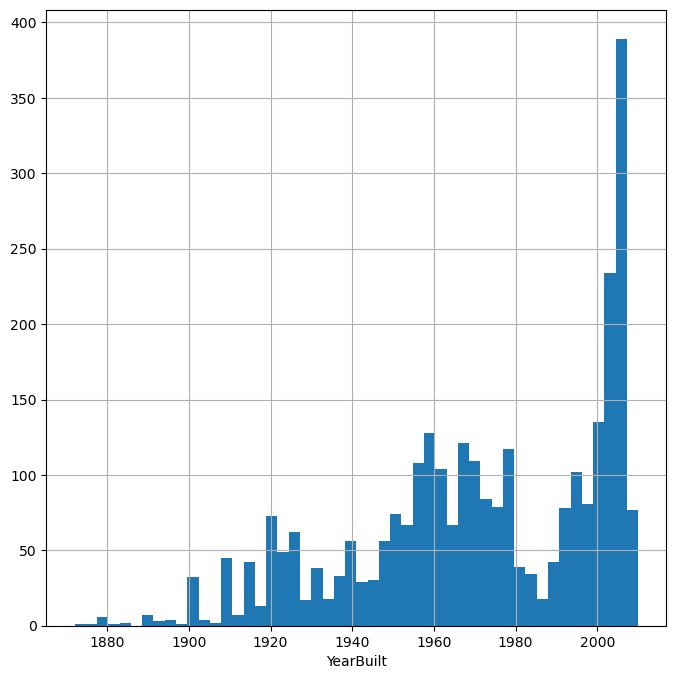

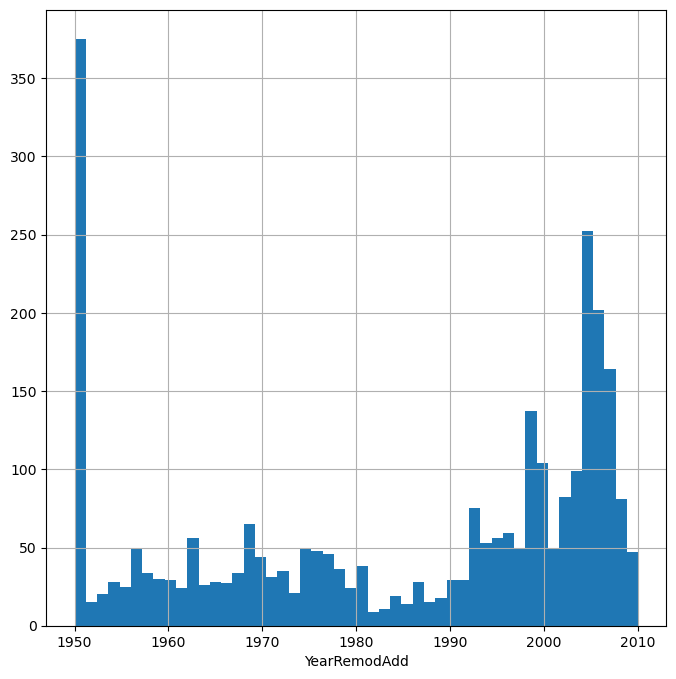

In [14]:
num_columns = ['OverallQual','GrLivArea','GarageArea','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd']
cat_columns = ['Foundation','BsmtQual','KitchenQual']
for var in num_columns:
    fig,ax = plt.subplots(figsize=(8,8))
    df[var].hist(bins=50,ax=ax)
    ax.set_xlabel(var)

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\2010246039.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['GrLivArea'], fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


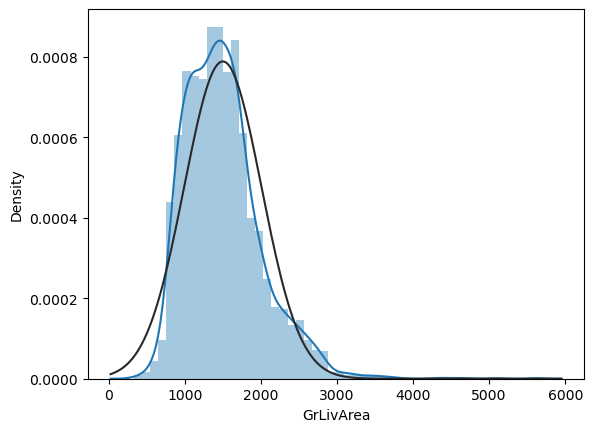

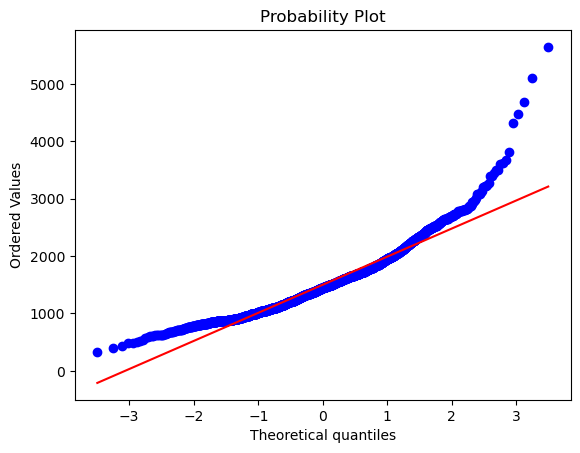

In [15]:
# 画直方图与连续概率估计，fit参数传入norm-标准正态分布
sns.distplot(df['GrLivArea'], fit=norm);
fig = plt.figure()
# probplot，样本数据相对于指定的理论分布(默认为正态分布)的分位数的概率。probplot可以计算出数据的最佳拟合线。这个图是用来看线性度的
res = probplot(df['GrLivArea'], plot=plt)

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\2475331815.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.sqrt(df['GrLivArea']), fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


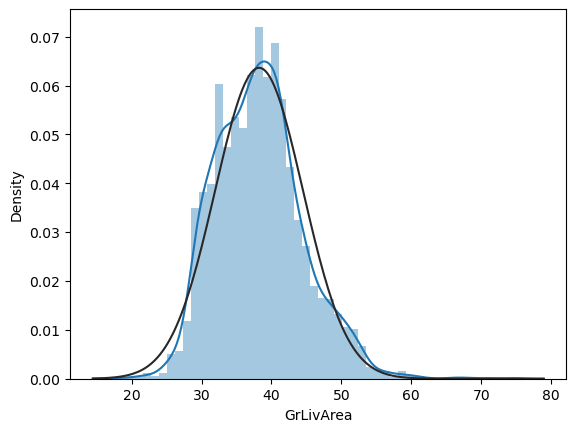

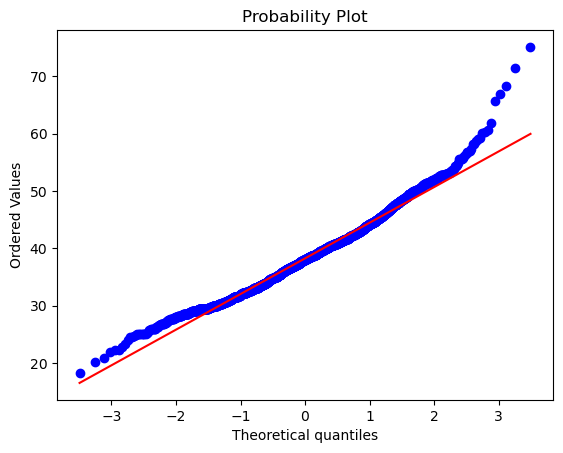

In [17]:
# 画直方图与连续概率估计，fit参数传入norm-标准正态分布
sns.distplot(np.sqrt(df['GrLivArea']), fit=norm);
fig = plt.figure()
# probplot，样本数据相对于指定的理论分布(默认为正态分布)的分位数的概率。probplot可以计算出数据的最佳拟合线。这个图是用来看线性度的
res = probplot(np.sqrt(df['GrLivArea']), plot=plt)

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\3159260326.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['GarageArea'], fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


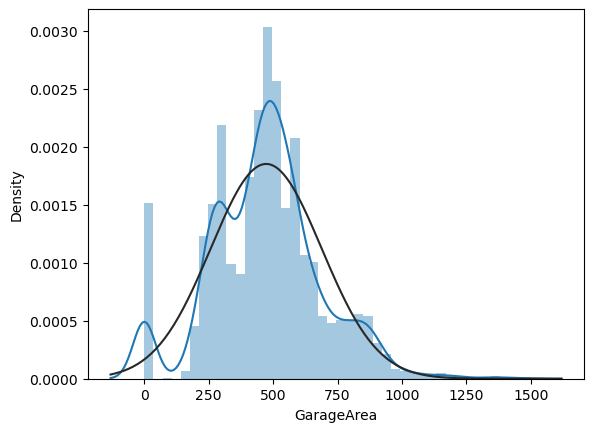

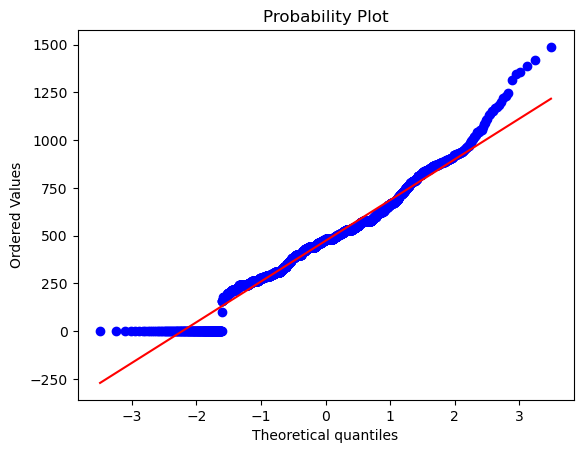

In [18]:
# 画直方图与连续概率估计，fit参数传入norm-标准正态分布
sns.distplot(df['GarageArea'], fit=norm);
fig = plt.figure()
# probplot，样本数据相对于指定的理论分布(默认为正态分布)的分位数的概率。probplot可以计算出数据的最佳拟合线。这个图是用来看线性度的
res = probplot(df['GarageArea'], plot=plt)

In [19]:
df['GarageArea'].kurtosis(),df['GarageArea'].skew()

(0.9411328710919817, 0.24134181815803954)

In [20]:
dfg = QuantileTransformer(n_quantiles = 300,output_distribution='normal', random_state=0).fit_transform(df['GarageArea'].values.reshape(-1,1))

In [21]:
dfg = pd.Series(dfg.flatten())

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\4089594581.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfg, fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


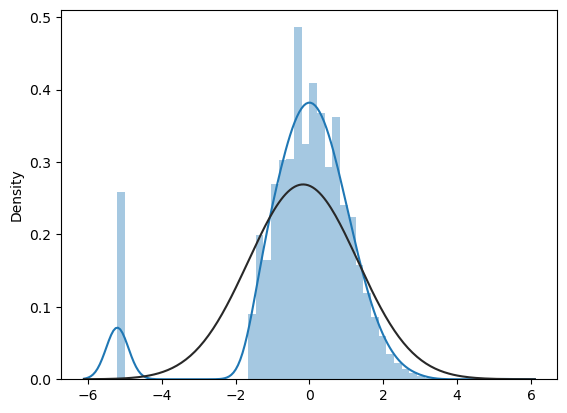

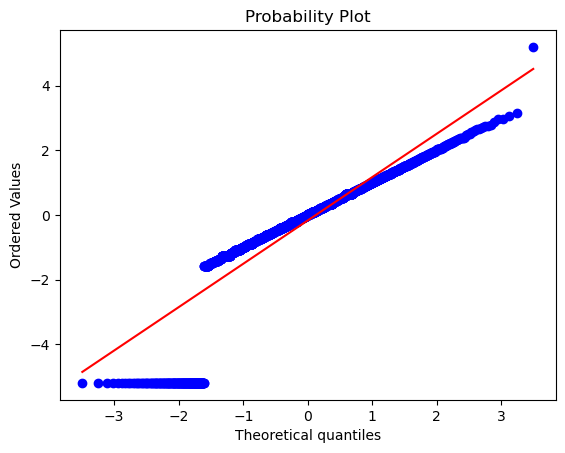

In [22]:
# 画直方图与连续概率估计，fit参数传入norm-标准正态分布
sns.distplot(dfg, fit=norm);
fig = plt.figure()
# probplot，样本数据相对于指定的理论分布(默认为正态分布)的分位数的概率。probplot可以计算出数据的最佳拟合线。这个图是用来看线性度的
res = probplot(dfg, plot=plt)

In [23]:
dfg.kurtosis(),dfg.skew()

(4.644983952199193, -1.8097104691236827)

In [26]:
df['GarageArea'].kurtosis(),df['GarageArea'].skew()

(11.528851346720263, -3.52129023344493)

IndentationError: unexpected indent (6958029.py, line 2)

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\271212196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['TotalBsmtSF'],bins=50,color='k')
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalBsmtSF', ylabel='Density'>

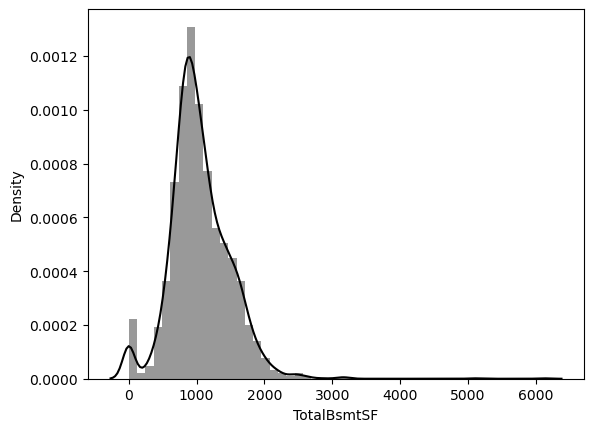

In [27]:
sns.distplot(df['TotalBsmtSF'],bins=50,color='k')

In [28]:
df['TotalBsmtSF'].kurtosis(),df['TotalBsmtSF'].skew()

(9.155258353595077, 1.1630815127320877)

In [29]:
dfgt = QuantileTransformer(n_quantiles = 300,output_distribution='normal', random_state=0).fit_transform(df['TotalBsmtSF'].values.reshape(-1,1))
dfgt = pd.Series(dfgt.flatten())

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\3455069407.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfgt, fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


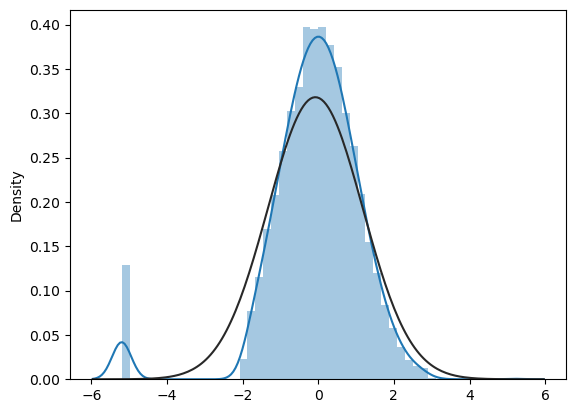

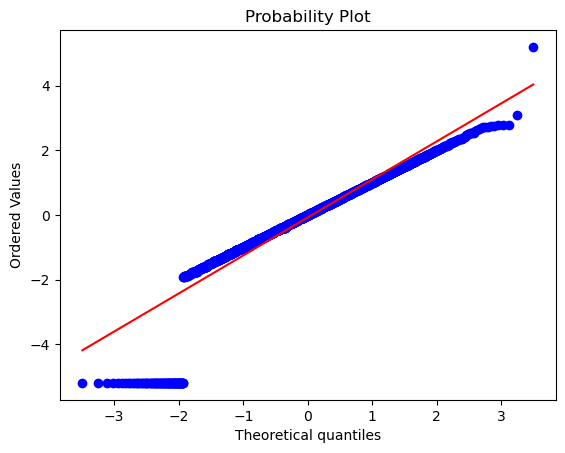

In [30]:
# 画直方图与连续概率估计，fit参数传入norm-标准正态分布
sns.distplot(dfgt, fit=norm);
fig = plt.figure()
# probplot，样本数据相对于指定的理论分布(默认为正态分布)的分位数的概率。probplot可以计算出数据的最佳拟合线。这个图是用来看线性度的
res = probplot(dfgt, plot=plt)

In [31]:
dfgt.kurtosis(),dfgt.skew()

(5.420574853104886, -1.5323653916203794)

C:\Users\摸鱼的葡式蛋挞\AppData\Local\Temp\ipykernel_2668\2057716195.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['HasBsmt']>0]['TotalBsmtSF'], fit=norm);
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


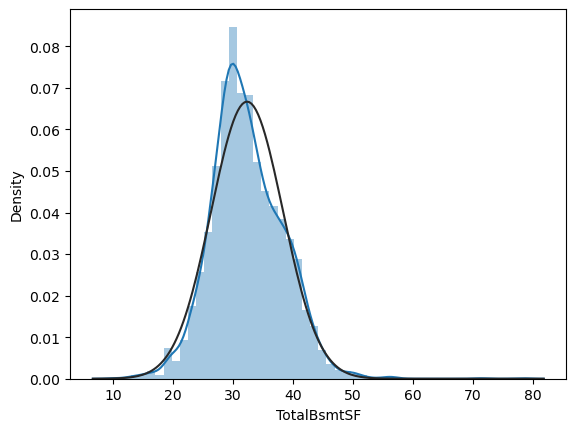

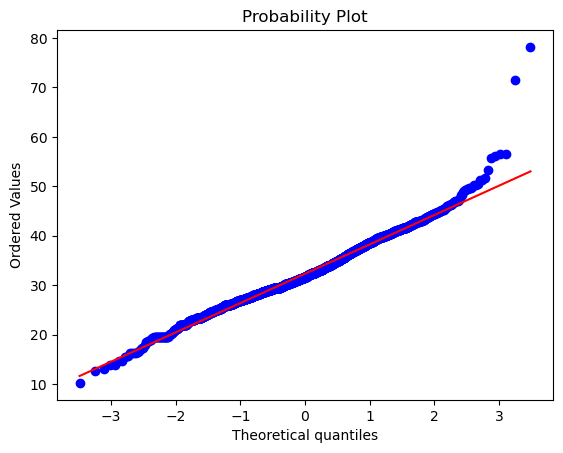

In [32]:
# 对大于等于0的数开根号
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.sqrt(df['TotalBsmtSF'])
sns.distplot(df[df['HasBsmt']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = probplot(df[df['HasBsmt']>0]['TotalBsmtSF'], plot=plt)

In [33]:
df['TotalBsmtSF'].kurtosis(),df['TotalBsmtSF'].skew()

(5.584358513537169, -1.3095078795716226)

In [34]:
df_process = df[num_columns]
df_process.loc[:,'GrLivArea'] = np.log1p(df.loc[:,'GrLivArea'])
dummy =[]
for var in cat_columns:
    dummy_df = pd.get_dummies(df[var],prefix=var)
    dummy.append(dummy_df)
df_process = pd.concat([df_process,dummy[0]],axis=1)
df_process = pd.concat([df_process,dummy[1]],axis=1)
df_process = pd.concat([df_process,dummy[2]],axis=1)
df_process

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,...,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,7,7.444833,6.306275,29.257478,2,2003,2003,False,False,True,...,False,False,False,False,True,False,False,False,True,False
2,6,7.141245,6.131226,35.524639,2,1976,1976,False,True,False,...,False,False,False,False,True,False,False,False,False,True
3,7,7.488294,6.410175,30.331502,2,2001,2002,False,False,True,...,False,False,False,False,True,False,False,False,True,False
4,7,7.448916,6.464588,27.495454,1,1915,1970,True,False,False,...,False,False,False,False,False,True,False,False,True,False
5,8,7.695758,6.728629,33.837849,2,2000,2000,False,False,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,4,6.996681,0.000000,23.366643,1,1970,1970,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2916,4,6.996681,5.655992,23.366643,1,1970,1970,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2917,5,7.110696,6.356108,34.985711,1,1960,1996,False,True,False,...,False,False,False,False,False,True,False,False,False,True


In [35]:
df_process.to_csv('df_dummy.csv')

In [36]:
df_process_1 = df[num_columns]
df_process_1.loc[:,'GrLivArea'] = np.log1p(df.loc[:,'GrLivArea'])
freq_dict = {}  # 频率字典
for var in cat_columns:
    for v in set(df[var]):
        vdf = df.loc[df.loc[:,var] == v][var]
        freq_dict[v] = vdf.shape[0] / df.shape[0]
    for i in range(df.shape[0]):
        df.loc[i+1,var] = freq_dict[df.loc[i+1,var]]
df_process_1 = pd.concat([df_process_1,df[cat_columns]],axis=1)
df_process_1

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Foundation,BsmtQual,KitchenQual
Id,,,,,,,,,,
1,7,7.444833,6.306275,29.257478,2,2003,2003,0.448099,0.414183,0.394313
2,6,7.141245,6.131226,35.524639,2,1976,1976,0.42309,0.414183,0.511477
3,7,7.488294,6.410175,30.331502,2,2001,2002,0.448099,0.414183,0.394313
4,7,7.448916,6.464588,27.495454,1,1915,1970,0.106543,0.463857,0.394313
5,8,7.695758,6.728629,33.837849,2,2000,2000,0.448099,0.414183,0.394313
...,...,...,...,...,...,...,...,...,...,...
2915,4,6.996681,0.000000,23.366643,1,1970,1970,0.42309,0.463857,0.511477
2916,4,6.996681,5.655992,23.366643,1,1970,1970,0.42309,0.463857,0.511477
2917,5,7.110696,6.356108,34.985711,1,1960,1996,0.42309,0.463857,0.511477


In [37]:
df_process_1.to_csv('df_freq.csv')

In [41]:
import pandas as pd
import numpy as np

# 数值型变量处理：对 GrLivArea 进行对数变换
df_process_1 = df[num_columns].copy()  # 复制数值型变量
df_process_1['GrLivArea'] = np.log1p(df['GrLivArea'])

# 频率字典
freq_dict = {}

# 计算分类变量的频率编码
for var in cat_columns:
    freq_dict[var] = df[var].value_counts(normalize=True).to_dict()  # 计算频率并存储为字典
    df[var] = df[var].map(freq_dict[var])  # 将分类变量替换为其频率

# 将频率编码后的分类变量拼接回数值型变量
df_process_1 = pd.concat([df_process_1, df[cat_columns]], axis=1)

df_process_1


,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Foundation,BsmtQual,KitchenQual
Id,,,,,,,,,,
1,7,7.444833,1.841545,29.257478,2,2003,2003,0.448099,0.414183,0.394313
2,6,7.141245,1.813395,35.524639,2,1976,1976,0.423090,0.414183,0.511477
3,7,7.488294,1.857887,30.331502,2,2001,2002,0.448099,0.414183,0.394313
4,7,7.448916,1.866339,27.495454,1,1915,1970,0.106543,0.463857,0.394313
5,8,7.695758,1.906371,33.837849,2,2000,2000,0.448099,0.414183,0.394313
...,...,...,...,...,...,...,...,...,...,...
2915,4,6.996681,0.000000,23.366643,1,1970,1970,0.423090,0.463857,0.511477
2916,4,6.996681,1.732715,23.366643,1,1970,1970,0.423090,0.463857,0.511477
2917,5,7.110696,1.849416,34.985711,1,1960,1996,0.423090,0.463857,0.511477


In [42]:
df_process_1.to_csv('df_freq.csv')